In [13]:
!pip install torch torchvision pandas matplotlib scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive
import os


# Mount Google Drive
drive.mount('/content/my-drive')
save_path = "/content/drive/MyDrive/Adversarial_Attack/"
os.makedirs(save_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Drive already mounted at /content/my-drive; to attempt to forcibly remount, call drive.mount("/content/my-drive", force_remount=True).


In [14]:
def load_data(batch_size=64):
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.GaussianBlur(kernel_size=3)  # Add smoothing
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

batch_size = 64
train_loader, test_loader = load_data(batch_size=batch_size)


Files already downloaded and verified
Files already downloaded and verified


In [15]:
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()
    perturbed_images = images + epsilon * images.grad.sign()
    return torch.clamp(perturbed_images, 0, 1)


In [16]:
def epsilon_scheduler(epoch, max_epsilon=0.1, ramp_up_epochs=50):
    return min(max_epsilon, max_epsilon * (epoch / ramp_up_epochs))


In [17]:
def train(model, train_loader, optimizer, device, use_adversarial=False, epsilon=0.1, clean_ratio=0.75):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        clean_count = int(len(images) * clean_ratio)
        clean_images, adv_images = images[:clean_count], images[clean_count:]
        clean_labels, adv_labels = labels[:clean_count], labels[clean_count:]

        if use_adversarial:
            adv_images = fgsm_attack(model, adv_images, adv_labels, epsilon=epsilon)
            images = torch.cat([clean_images, adv_images])
            labels = torch.cat([clean_labels, adv_labels])

        optimizer.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)

def evaluate(model, test_loader, device, attack=None, epsilon=0.1):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        if attack:
            images = attack(model, images, labels, epsilon=epsilon)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return 100 * correct / total


In [18]:


def train_and_evaluate(model, model_name, train_loader, test_loader, device, epochs=200):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs // 2)
    metrics = []

    for epoch in range(epochs):
        epsilon = epsilon_scheduler(epoch)
        use_adversarial = (epoch >= epochs // 2)
        avg_loss = train(model, train_loader, optimizer, device, use_adversarial=use_adversarial, epsilon=epsilon)
        scheduler.step()

        clean_accuracy = evaluate(model, test_loader, device)
        fgsm_accuracy = evaluate(model, test_loader, device, attack=fgsm_attack, epsilon=0.1)
        robustness_score = clean_accuracy - fgsm_accuracy

        metrics.append({"Epoch": epoch + 1, "Loss": avg_loss, "Clean Accuracy": clean_accuracy,
                        "FGSM Accuracy": fgsm_accuracy, "Robustness Score": robustness_score})
        pd.DataFrame(metrics).to_csv(f"{save_path}{model_name}_metrics.csv", index=False)

        print(f"{model_name} - Epoch {epoch + 1}/{epochs}: Loss={avg_loss:.4f}, Clean={clean_accuracy:.2f}%, "
              f"FGSM={fgsm_accuracy:.2f}%, Robustness={robustness_score:.2f}%")


In [19]:
class EnhancedSimpleCNN(nn.Module):
    def __init__(self):
        super(EnhancedSimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8192, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [20]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.model(x)


In [21]:
import torch.nn as nn
import torch.nn.functional as F

# VGG-Style CNN Model
class VGGStyleCNN(nn.Module):
    def __init__(self):
        super(VGGStyleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [22]:
# Moderate CNN Model
class ModerateCNN(nn.Module):
    def __init__(self):
        super(ModerateCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train EnhancedSimpleCNN
simple_cnn_model = EnhancedSimpleCNN()
print("Training Enhanced Simple CNN...")
train_and_evaluate(simple_cnn_model, "EnhancedSimpleCNN", train_loader, test_loader, device, epochs=200)

# Train Pretrained ResNet18
resnet18_model = ResNet18()
print("Training Resnet 18 CNN...")
train_and_evaluate(resnet18_model, "ResNet18", train_loader, test_loader, device, epochs=200)

# Train and evaluate VGG-Style CNN
vgg_model = VGGStyleCNN()
print("Training VGG-Style CNN...")
train_and_evaluate(vgg_model, "VGGStyleCNN", train_loader, test_loader, device, epochs=200)

# Train and evaluate Moderate CNN
moderate_cnn_model = ModerateCNN()
print("Training Moderate CNN...")
train_and_evaluate(moderate_cnn_model, "ModerateCNN", train_loader, test_loader, device, epochs=200)



Training Enhanced Simple CNN...
EnhancedSimpleCNN - Epoch 1/3: Loss=1.5644, Clean=53.75%, FGSM=8.37%, Robustness=45.38%
EnhancedSimpleCNN - Epoch 2/3: Loss=1.5993, Clean=53.75%, FGSM=8.37%, Robustness=45.38%
EnhancedSimpleCNN - Epoch 3/3: Loss=1.3791, Clean=57.98%, FGSM=9.07%, Robustness=48.91%


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]


Training Resnet 18 CNN...
ResNet18 - Epoch 1/3: Loss=1.2155, Clean=68.97%, FGSM=7.57%, Robustness=61.40%
ResNet18 - Epoch 2/3: Loss=1.2383, Clean=68.19%, FGSM=7.86%, Robustness=60.33%
ResNet18 - Epoch 3/3: Loss=1.0617, Clean=69.73%, FGSM=9.76%, Robustness=59.97%
Training VGG-Style CNN...
VGGStyleCNN - Epoch 1/3: Loss=1.6581, Clean=49.79%, FGSM=9.93%, Robustness=39.86%
VGGStyleCNN - Epoch 2/3: Loss=1.9482, Clean=49.79%, FGSM=9.93%, Robustness=39.86%
VGGStyleCNN - Epoch 3/3: Loss=1.4668, Clean=57.39%, FGSM=13.60%, Robustness=43.79%
Training Moderate CNN...
ModerateCNN - Epoch 1/3: Loss=1.6854, Clean=50.19%, FGSM=10.27%, Robustness=39.92%
ModerateCNN - Epoch 2/3: Loss=1.7406, Clean=50.19%, FGSM=10.27%, Robustness=39.92%
ModerateCNN - Epoch 3/3: Loss=1.4983, Clean=53.36%, FGSM=14.37%, Robustness=38.99%


In [23]:
def plot_comparative_analysis():
    comparison_file = f"{save_path}Comparative_Analysis.csv"
    data = pd.read_csv(comparison_file)

    metrics = ['Clean Accuracy', 'FGSM Accuracy', 'Robustness Score']
    for metric in metrics:
        plt.figure()
        plt.bar(data['Model'], data[metric], color=['blue', 'orange'])
        plt.ylabel(f'{metric} (%)')
        plt.title(f'Comparative Analysis - {metric}')
        plt.savefig(f"{save_path}Comparative_{metric.replace(' ', '_')}.png")
        plt.show()


In [24]:
def comparative_analysis():
    simple_metrics = pd.read_csv(f"{save_path}EnhancedSimpleCNN_metrics.csv").iloc[-1]
    resnet_metrics = pd.read_csv(f"{save_path}ResNet18_metrics.csv").iloc[-1]
    vgg_metrics = pd.read_csv(f"{save_path}VGGStyleCNN_metrics.csv").iloc[-1]
    moderate_metrics = pd.read_csv(f"{save_path}ModerateCNN_metrics.csv").iloc[-1]

    comparison = pd.DataFrame({
        "Model": ["EnhancedSimpleCNN", "ResNet18", "VGGStyleCNN", "ModerateCNN"],
        "Clean Accuracy": [simple_metrics["Clean Accuracy"], resnet_metrics["Clean Accuracy"],
                           vgg_metrics["Clean Accuracy"], moderate_metrics["Clean Accuracy"]],
        "FGSM Accuracy": [simple_metrics["FGSM Accuracy"], resnet_metrics["FGSM Accuracy"],
                          vgg_metrics["FGSM Accuracy"], moderate_metrics["FGSM Accuracy"]],
        "Robustness Score": [simple_metrics["Robustness Score"], resnet_metrics["Robustness Score"],
                             vgg_metrics["Robustness Score"], moderate_metrics["Robustness Score"]]
    })
    print(comparison)
    comparison.to_csv(f"{save_path}Comparative_Analysis.csv", index=False)
    comparison.plot(x="Model", y=["Clean Accuracy", "FGSM Accuracy", "Robustness Score"], kind="bar", figsize=(10, 6))
    plt.title("Comparative Analysis of Models")
    plt.ylabel("Accuracy (%)")
    plt.show()


In [25]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_file, model_name):
    data = pd.read_csv(metrics_file)

    # Loss Plot
    plt.figure()
    plt.plot(data['Epoch'], data['Loss'], label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Over Epochs')
    plt.legend()
    plt.savefig(f"{save_path}{model_name}_Loss.png")
    plt.show()

    # Clean Accuracy Plot
    plt.figure()
    plt.plot(data['Epoch'], data['Clean Accuracy'], label='Clean Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} - Clean Accuracy Over Epochs')
    plt.legend()
    plt.savefig(f"{save_path}{model_name}_Clean_Accuracy.png")
    plt.show()

    # FGSM Accuracy Plot
    plt.figure()
    plt.plot(data['Epoch'], data['FGSM Accuracy'], label='FGSM Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} - FGSM Accuracy Over Epochs')
    plt.legend()
    plt.savefig(f"{save_path}{model_name}_FGSM_Accuracy.png")
    plt.show()

    # Robustness Score Plot
    plt.figure()
    plt.plot(data['Epoch'], data['Robustness Score'], label='Robustness Score', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Score (%)')
    plt.title(f'{model_name} - Robustness Score Over Epochs')
    plt.legend()
    plt.savefig(f"{save_path}{model_name}_Robustness_Score.png")
    plt.show()


In [26]:
import pandas as pd

def generate_comparative_analysis(save_path):
    enhanced_simplecnn_path = f"{save_path}EnhancedSimpleCNN_metrics.csv"
    resnet18_path = f"{save_path}ResNet18_metrics.csv"

    # Check if both metrics files exist
    if not os.path.exists(enhanced_simplecnn_path) or not os.path.exists(resnet18_path):
        raise FileNotFoundError("Metrics files are missing. Run the training for both models.")

    # Load metrics and compute comparison
    simple_metrics = pd.read_csv(enhanced_simplecnn_path).iloc[-1]
    resnet_metrics = pd.read_csv(resnet18_path).iloc[-1]
    comparison = pd.DataFrame({
        "Model": ["EnhancedSimpleCNN", "ResNet18"],
        "Clean Accuracy": [simple_metrics["Clean Accuracy"], resnet_metrics["Clean Accuracy"]],
        "FGSM Accuracy": [simple_metrics["FGSM Accuracy"], resnet_metrics["FGSM Accuracy"]],
        "Robustness Score": [simple_metrics["Robustness Score"], resnet_metrics["Robustness Score"]]
    })

    # Save the comparative analysis
    comparison_path = f"{save_path}Comparative_Analysis.csv"
    comparison.to_csv(comparison_path, index=False)
    print(f"Comparative analysis saved to {comparison_path}")
    return comparison

In [27]:
comparison = generate_comparative_analysis(save_path)

Comparative analysis saved to /content/drive/MyDrive/Adversarial_Attack/Comparative_Analysis.csv


In [28]:
def visualize_examples(model, test_loader, device, attack, epsilon):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    adv_images = attack(model, images, labels, epsilon)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        # Original images
        axes[0, i].imshow(images[i].permute(1, 2, 0).cpu().detach().numpy())
        axes[0, i].set_title(f"Original: {labels[i].item()}")
        axes[0, i].axis('off')

        # Adversarial images
        axes[1, i].imshow(adv_images[i].permute(1, 2, 0).cpu().detach().numpy())
        axes[1, i].set_title(f"Adversarial")
        axes[1, i].axis('off')

    plt.suptitle("Clean and Adversarial Examples")
    plt.savefig(f"{save_path}Visual_Examples.png")
    plt.show()

In [29]:
import matplotlib.pyplot as plt

def plot_comparative_analysis():
    comparison_path = f"{save_path}Comparative_Analysis.csv"
    if not os.path.exists(comparison_path):
        raise FileNotFoundError(f"Comparative Analysis file not found at {comparison_path}")

    # Load comparison data
    comparison = pd.read_csv(comparison_path)

    # Plot the results
    metrics = ["Clean Accuracy", "FGSM Accuracy", "Robustness Score"]
    fig, ax = plt.subplots(figsize=(10, 6))
    for metric in metrics:
        ax.plot(comparison["Model"], comparison[metric], marker='o', label=metric)

    ax.set_title("Model Comparative Analysis")
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel("Model")
    ax.legend()
    plt.grid()
    plt.show()


In [30]:
import pandas as pd

def display_average_metrics():
    # Load metrics from CSV files
    simple_metrics = pd.read_csv(f"{save_path}EnhancedSimpleCNN_metrics.csv")
    resnet_metrics = pd.read_csv(f"{save_path}ResNet18_metrics.csv")

    # Calculate averages for EnhancedSimpleCNN
    avg_simple_clean = simple_metrics["Clean Accuracy"].mean()
    avg_simple_fgsm = simple_metrics["FGSM Accuracy"].mean()
    avg_simple_robustness = simple_metrics["Robustness Score"].mean()

    # Calculate averages for ResNet18
    avg_resnet_clean = resnet_metrics["Clean Accuracy"].mean()
    avg_resnet_fgsm = resnet_metrics["FGSM Accuracy"].mean()
    avg_resnet_robustness = resnet_metrics["Robustness Score"].mean()

    # Display results
    print("Average Metrics for EnhancedSimpleCNN:")
    print(f"  Clean Accuracy: {avg_simple_clean:.2f}%")
    print(f"  FGSM Accuracy: {avg_simple_fgsm:.2f}%")
    print(f"  Robustness Score: {avg_simple_robustness:.2f}%")

    print("\nAverage Metrics for ResNet18:")
    print(f"  Clean Accuracy: {avg_resnet_clean:.2f}%")
    print(f"  FGSM Accuracy: {avg_resnet_fgsm:.2f}%")
    print(f"  Robustness Score: {avg_resnet_robustness:.2f}%")

# Call the function to display averages
display_average_metrics()

Average Metrics for EnhancedSimpleCNN:
  Clean Accuracy: 55.16%
  FGSM Accuracy: 8.60%
  Robustness Score: 46.56%

Average Metrics for ResNet18:
  Clean Accuracy: 68.96%
  FGSM Accuracy: 8.40%
  Robustness Score: 60.57%


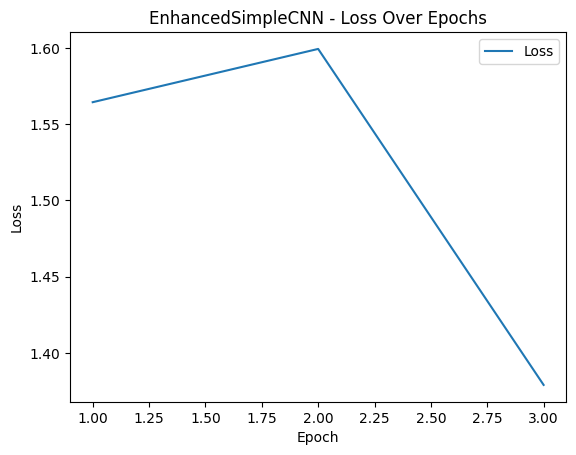

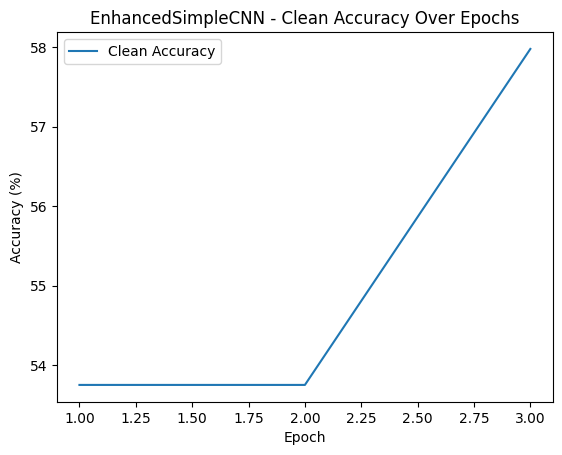

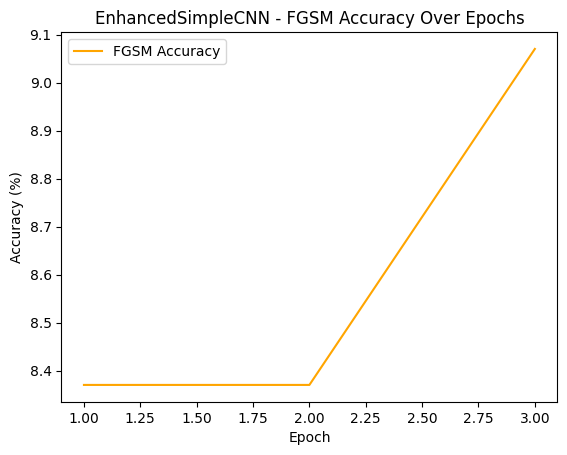

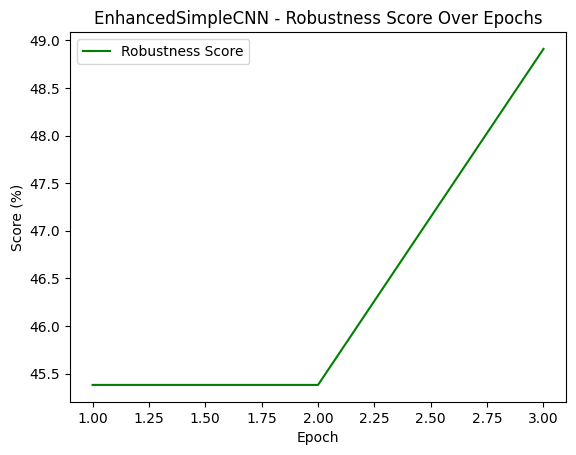

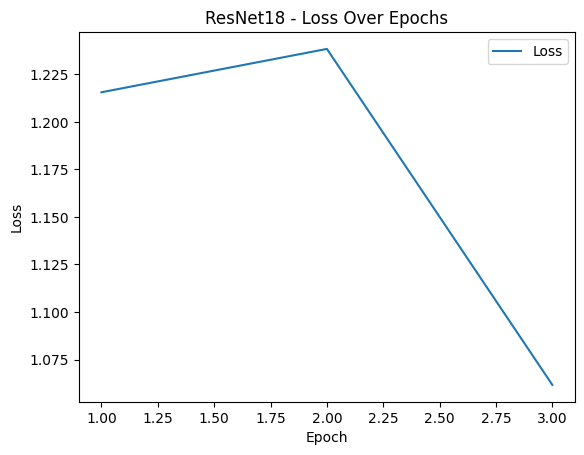

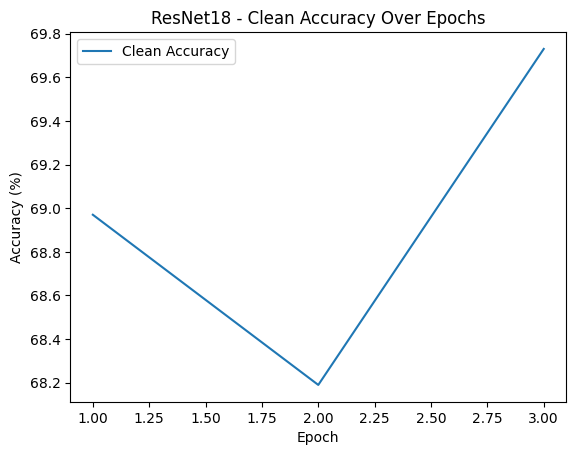

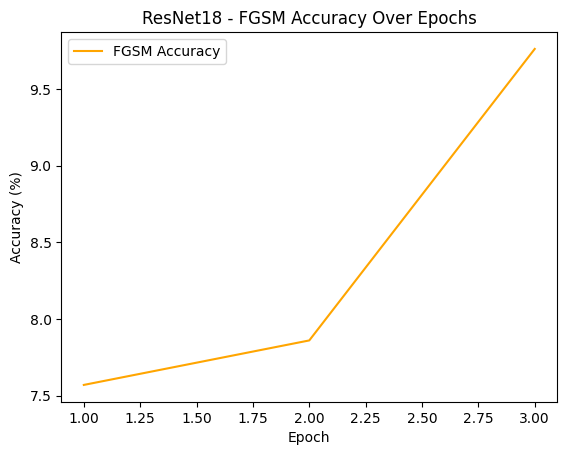

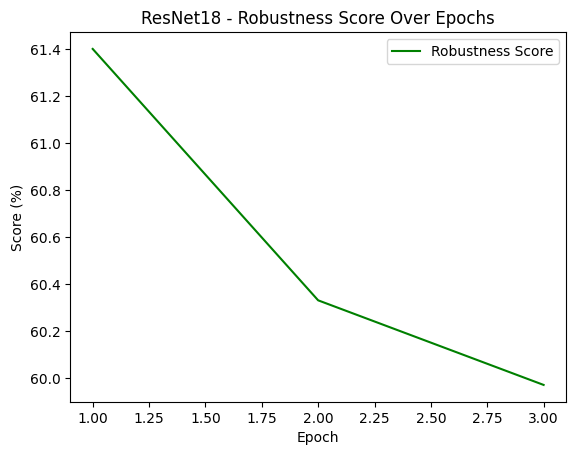

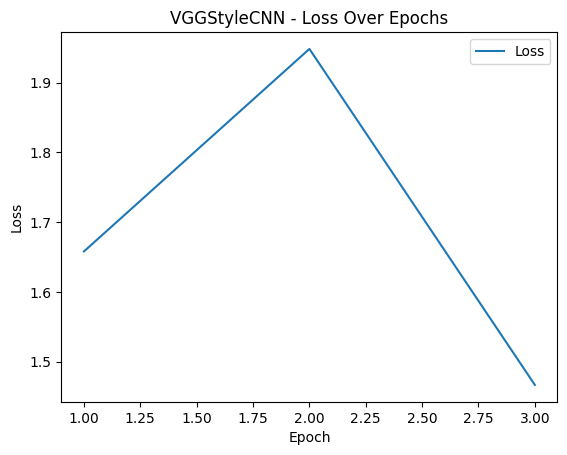

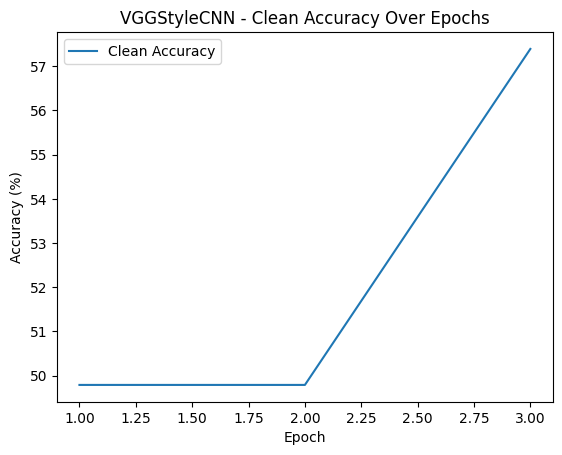

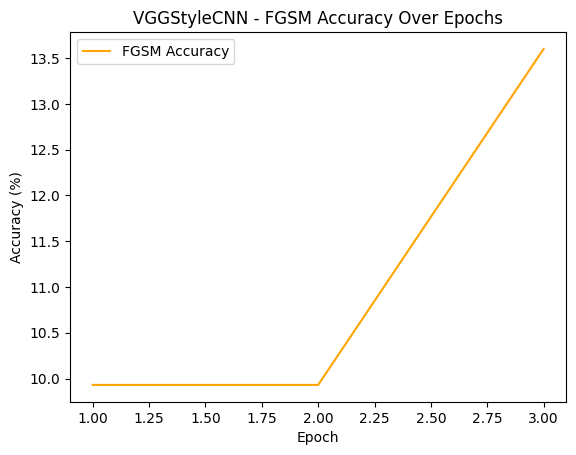

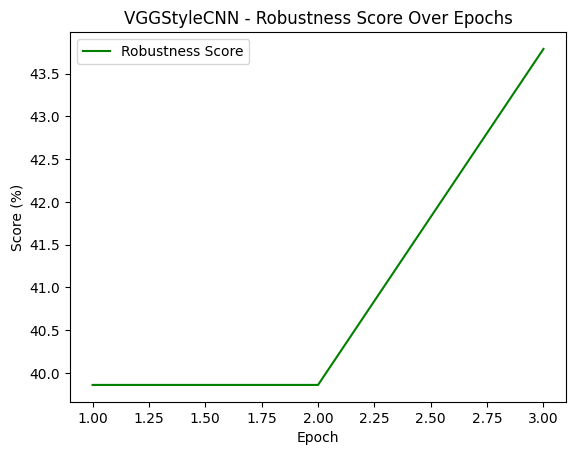

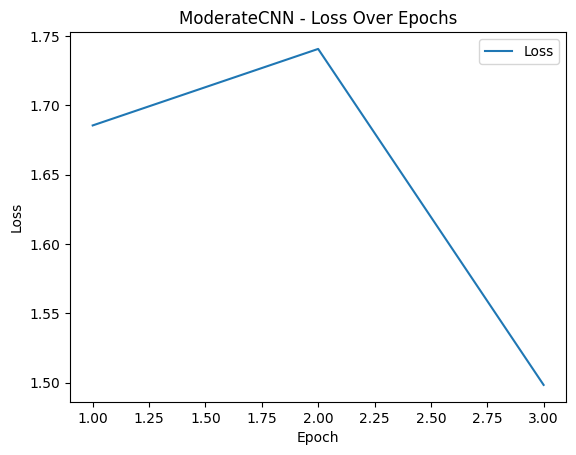

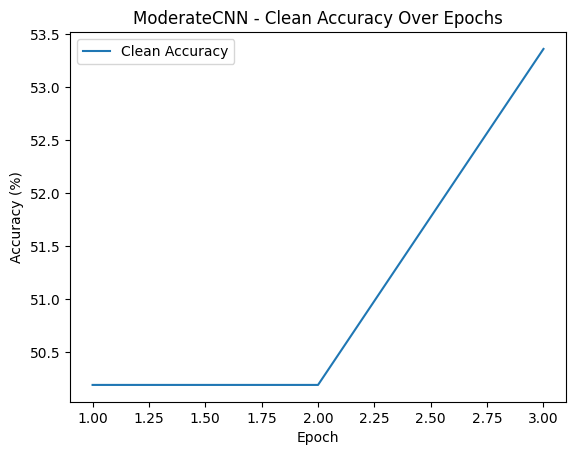

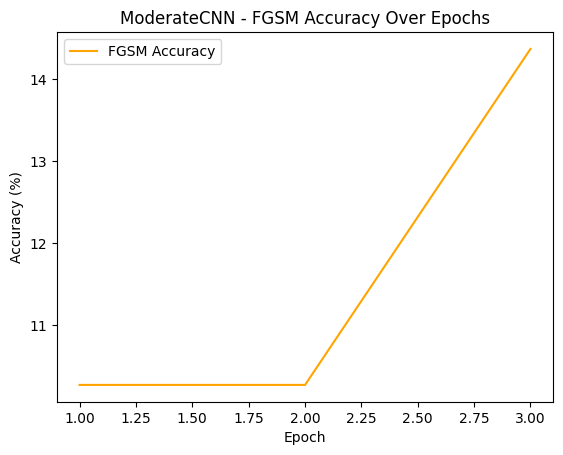

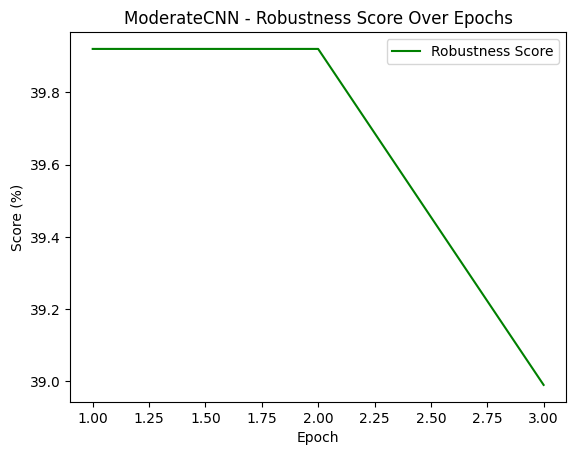

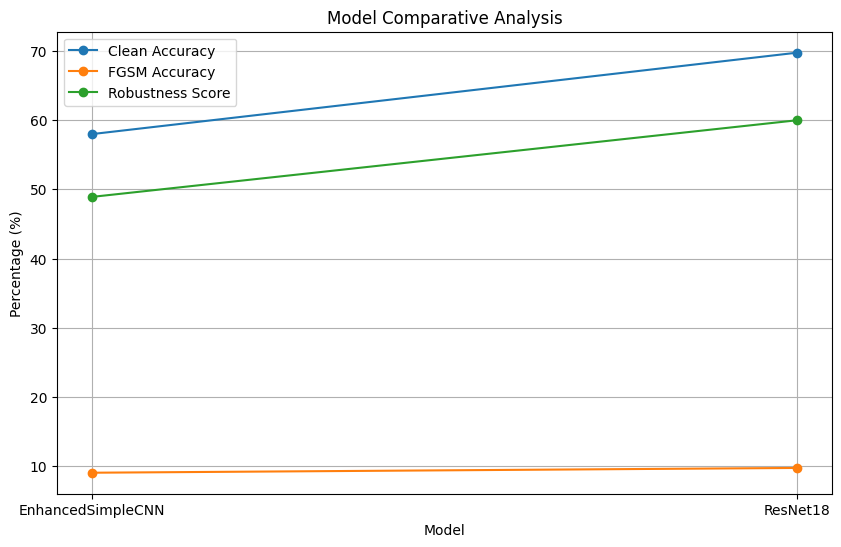

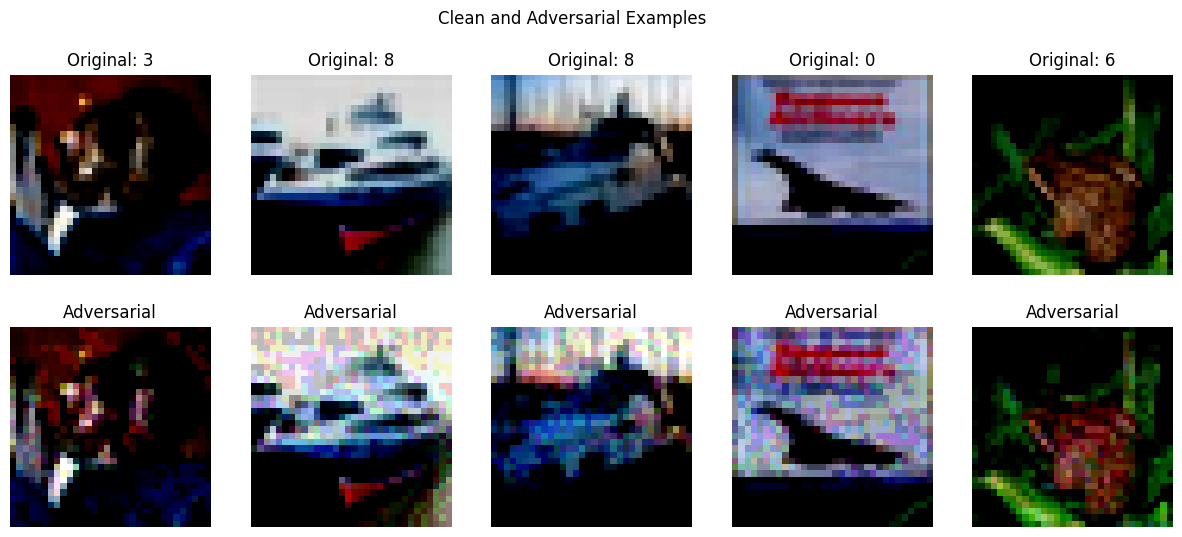

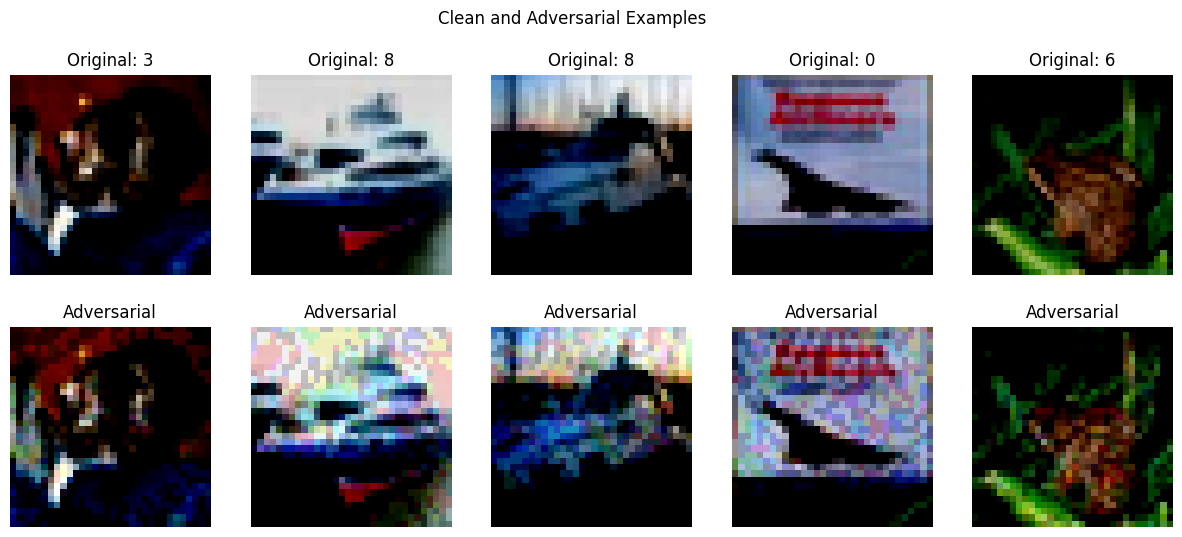

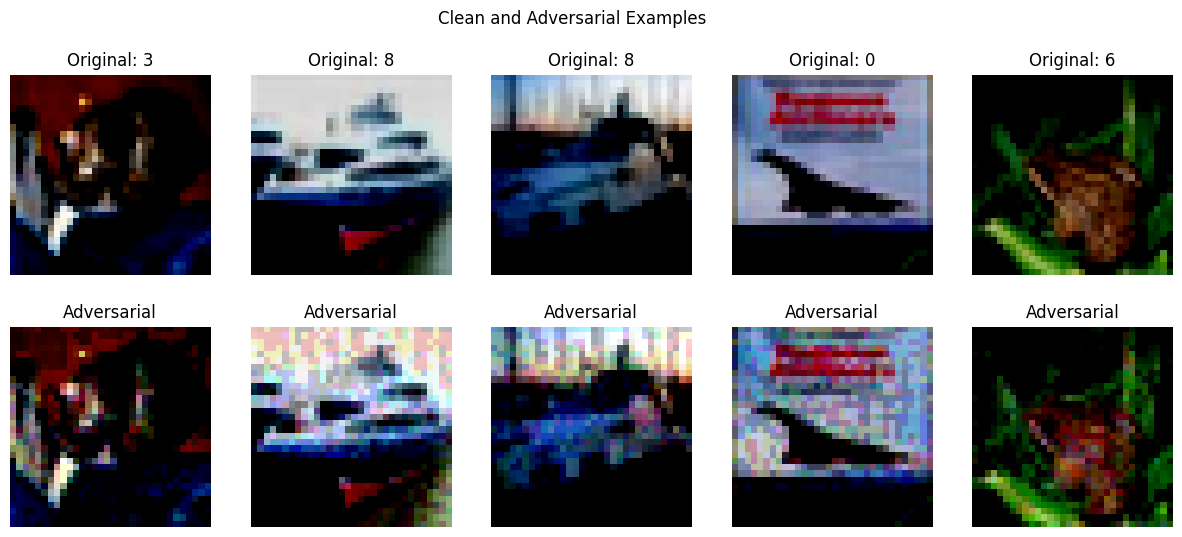

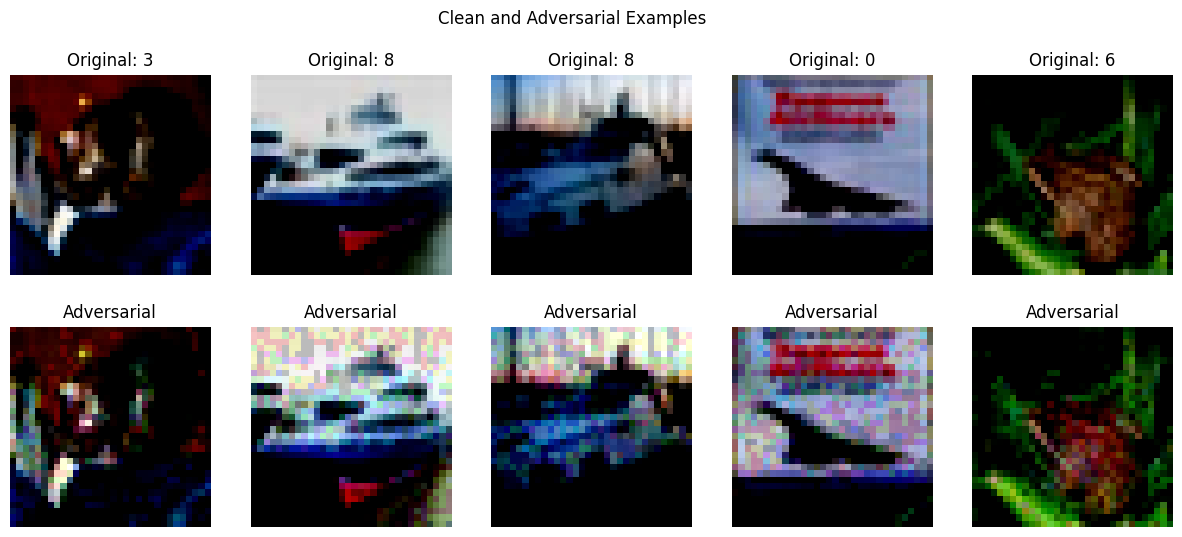

In [31]:
# Plot metrics for EnhancedSimpleCNN
plot_metrics(f"{save_path}EnhancedSimpleCNN_metrics.csv", "EnhancedSimpleCNN")

# Plot metrics for ResNet18
plot_metrics(f"{save_path}ResNet18_metrics.csv", "ResNet18")

# Plot metrics for VGG-Style CNN
plot_metrics(f"{save_path}VGGStyleCNN_metrics.csv", "VGGStyleCNN")

# Plot metrics for Moderate CNN
plot_metrics(f"{save_path}ModerateCNN_metrics.csv", "ModerateCNN")


# Plot comparative analysis
plot_comparative_analysis()

# Visualize examples for EnhancedSimpleCNN
visualize_examples(simple_cnn_model, test_loader, device, fgsm_attack, epsilon=0.1)

# Visualize examples for ResNet18
visualize_examples(resnet18_model, test_loader, device, fgsm_attack, epsilon=0.1)

# Visualize examples for VGG-Style CNN
visualize_examples(vgg_model, test_loader, device, fgsm_attack, epsilon=0.1)

# Visualize examples for Moderate CNN
visualize_examples(moderate_cnn_model, test_loader, device, fgsm_attack, epsilon=0.1)
